In [1]:
from Interpretation import *
import numpy as np

In [2]:
sequence = 'ALEYQYVMKNPKQLSFEKFSRRLSAKAFSVKKLLTNDDLSNDIHRGYLLLQGKSLDGLLETMIQEVKEIFESRLLKLTDWNTARVFDFCSSLVFEITFTTIYGKILAANKKQIISELRDDFLKFDDHFPYLVSDIPIQLLRNAEFMQKKIIKCLTPEKVAQMQRRSEIVQERQEMLKKYYGHEEFEIGAHHLGLLWASLANTIPAMFWAMYYLLQHPEAMEVLRDEIDSFLQSTGQKKGPGISVHFTREQLDSLVCLESAILEVLRLCSYSSIIREVQEDMDFSSESRSYRLRKGDFVAVFPPMIHNDPEVFDAPKDFRFDRFVEDGKKKTTFFKGGKKLKSYIIPFGLGTSKCPGRYFAINEMKLLVIILLTYFDLEVIDTKPIGLNHSRMFLGIQHPDSDISFRYKAKSWRS'
seq_length = len(sequence)

In [3]:
model = DeepEC_KAN()
model.eval()
checkpoint = torch.load('./model_inter.ckpt', map_location=torch.device('cpu'))
model.load_state_dict(checkpoint, strict=False);

checkpoint directory created: ./model
saving model version 0.0


In [4]:
class SeqEncoder:
    def __init__(self):
        self.categories = np.array(list('ACDEFGHIKLMNPQRSTVWYX'))

    def char_to_one_hot_encoding(self, c):
        X_int = np.zeros(len(self.categories), dtype=np.int8)
        index = np.where(self.categories == c)[0]

        if len(index) == 0: return X_int

        X_int[index] = 1
        return X_int

    def seq_to_one_hot_encoding(self, seq):
        return np.array([self.char_to_one_hot_encoding(c) for c in seq])

    def one_hot_encoding_to_seq(self, one_hot_encoding):
        X = np.array(one_hot_encoding).reshape(-1, 21)
        last_index = np.where(np.sum(X, axis=1) == 0)[0]
        last_index = 1000 if len(last_index) == 0 else last_index[0]
        return ''.join(self.categories[X.argmax(axis=1)][:last_index])

In [5]:
sequence = sequence + ' ' * (1000 - len(sequence))
sequence = SeqEncoder().seq_to_one_hot_encoding(sequence)

In [6]:
input_model = torch.Tensor(sequence).unsqueeze(0)

In [7]:
final_score, indices1, indices2, indices3 = model.forward(input_model)

/home/dumontet/conda/envs/kan_env/lib/python3.9/site-packages/kan/MultKAN.py:402: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1760.)
  self.subnode_actscale.append(torch.std(x, dim=0).detach())
/home/dumontet/conda/envs/kan_env/lib/python3.9/site-packages/kan/MultKAN.py:412: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1760.)
  input_range = torch.std(preacts, dim=0) + 0.1
/home/dumontet/conda/envs/kan_env/lib/python3.9/site-packages/kan/MultKAN.py:413: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cp

In [8]:
contribution_scores = interpretation(model.KAN, final_score)

In [9]:
contribution_scores = map_inter_to_input(contribution_scores, indices1, indices2, indices3)

<Axes: >

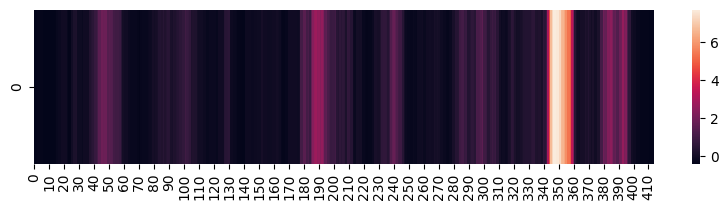

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,2))
sns.heatmap(contribution_scores.reshape((1,-1))[:, :seq_length])